In [1]:
from helpers import toWei, fromWei, UsdEthConverter, Market

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

usd = UsdEthConverter(162) # $162 per ETH, round to 3 digits

In [2]:
params = {
    'price_floor':          5e5,   # wei per billion CMT-wei

    'spread':               110,  # percentage
    
    'usd_list_reward':      0.25, # $USD per listing
    # This is tricky. Too high and acceptable but not appealing listings will soak up
    # early capitalization but not contribute revenue.
    
    'stake':                toWei(10, 'CMT'),
    
    'backend_payment':      5, # percent
    
    'maker_payment':        70, # percent. 
    
    # reserve payment:      100 - backend_payment - maker_payment
    
    'usd_cost_per_mbyte':       0.10 # $USD per Mbyte
    # A scan through some Kaggle datasets, the size of videos, photos, and sound files, and came
    # up with 100MB as a reference listing size. Let's make buying this reference 1 ETH. You can 
    # easily get 3 ETHs from the faucet and buy 3 things.
}

In [3]:
# Convert human readable units to units used by market codebase
params['reserve_payment'] = 100 - params['backend_payment'] - params['maker_payment']
params['cost_per_byte'] = toWei(usd.toEth(params['usd_cost_per_mbyte']), 'ETH') / 1e6
params['list_reward'] = toWei(usd.toEth(params['usd_list_reward']), 'CMT')

## Set up market with 3 creators each investing $166

In [4]:
total_creator_usd = 500
n_creators = 3
creator_usd = total_creator_usd/n_creators
##################

m = Market(params)
m.market_total += toWei(1e-3, 'CMT')

for i in range(3):
    print (f"Supporter {i+1} pays ${round(usd.fromEth(m.get_human_support_price()),2)} per CMT")
    m.support(usd.toEth(creator_usd))
    
CREATOR_BLOCK_SIZE = m.market_total

print (f"CMT withdraw price is now ${round(usd.fromEth(m.get_withdraw_price()),2)}")
print ("\n")

print (f"• Market reserve is {round(fromWei(m.reserve, 'ETH'),3)} ETH (${round(usd.fromEth(fromWei(m.reserve, 'ETH')),2)})")
print (f"• Market tokens is {round(fromWei(m.market_total, 'CMT'), 2)} CMT")

print ("\n")
print (f"• The creator has {int(CREATOR_BLOCK_SIZE/params['stake'])} stakes of voting power")

listings_approved_to_match_creator = CREATOR_BLOCK_SIZE / params['list_reward']
print (f"• It takes {int(listings_approved_to_match_creator)} listings to match creator voting power")

Supporter 1 pays $0.08 per CMT
Supporter 2 pays $0.17 per CMT
Supporter 3 pays $0.2 per CMT
CMT withdraw price is now $0.13


• Market reserve is 3.086 ETH ($500.0)
• Market tokens is 3863.68 CMT


• The creator has 386 stakes of voting power
• It takes 2503661 listings to match creator voting power


## Scenario: simple sequence of supporting, listing, buying

In [5]:
iters = 1000

support_prices_usd = np.zeros(iters)
withdraw_prices_usd = np.zeros(iters)

support_usd = 5.0
buy_mb = 10.0

for i in range(iters):
    m.support(usd.toEth(support_usd))
    m.list()
    for j in range(10):
        m.buy(buy_mb)
    
    support_prices_usd[i] = usd.fromEth(m.get_human_support_price())
    withdraw_prices_usd[i] = usd.fromEth(m.get_withdraw_price())

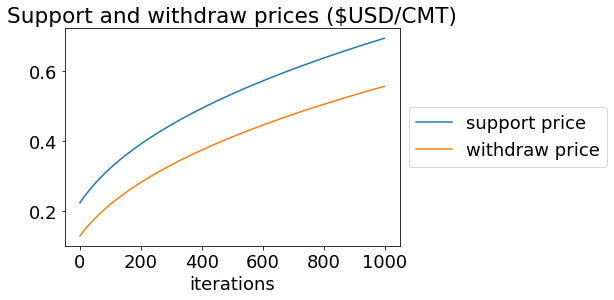

In [6]:
plt.rc('font', size=18)
fig, ax = plt.subplots()

x = np.arange(0, iters, 1)
ax.plot(x, support_prices_usd)
ax.plot(x, withdraw_prices_usd)
ax.legend(['support price', 'withdraw price'], loc='center left', bbox_to_anchor=(1, 0.5))

ax.set(xlabel='iterations', title='Support and withdraw prices ($USD/CMT)')
plt.show()

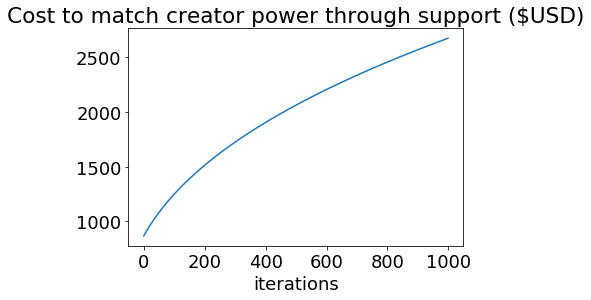

In [7]:
costs_to_match_creator = fromWei(CREATOR_BLOCK_SIZE, 'CMT') * support_prices_usd

fig, ax = plt.subplots()
ax.plot(x, costs_to_match_creator)
ax.set(xlabel='iterations', title='Cost to match creator power through support ($USD)')
plt.show()

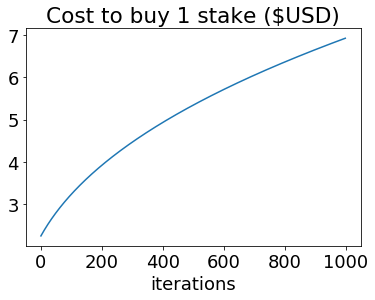

In [8]:
costs_to_stake = fromWei(params['stake'], 'CMT') * support_prices_usd

fig, ax = plt.subplots()
ax.plot(x, costs_to_stake)
ax.set(xlabel='iterations', title='Cost to buy 1 stake ($USD)')
plt.show()

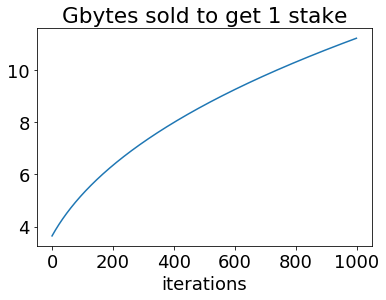

In [9]:
mb_sold_to_stake = costs_to_stake / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_stake/1000)
ax.set(xlabel='iterations', title='Gbytes sold to get 1 stake')
plt.show()

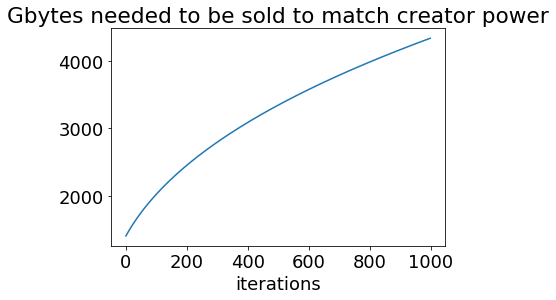

In [10]:
mb_sold_to_match_creator = costs_to_match_creator / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_match_creator/1000)
ax.set(xlabel='iterations', title='Gbytes needed to be sold to match creator power')
plt.show()